In [1]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=a7c9001e90c0cdc15f02d109558a8f9de9e77984c04408ec21c4effa015a13cb
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
import nltk

# Download the 'punkt' tokenizer data
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# Sample speeches (replace these with your actual speeches)
actual_speeches = [
    "I am honored to be here today. Our country faces many challenges, but together, we can overcome them.",
    "The future of our nation is bright, and I will work tirelessly to ensure a better tomorrow for all.",
]

generated_speeches = [
    "I am humbled to be present in this gathering. Our nation confronts numerous obstacles, but united, we shall prevail.",
    "The destiny of our land is promising, and I will tirelessly strive to guarantee a brighter future for everyone.",
]

# Preprocess the texts (optional but recommended)
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = " ".join(nltk.word_tokenize(text))  # Tokenize text into words
    return text

actual_speeches = [preprocess_text(text) for text in actual_speeches]
generated_speeches = [preprocess_text(text) for text in generated_speeches]

# Calculate BLEU score for each generated speech compared to its corresponding actual speech
bleu_scores = []
for actual_speech, generated_speech in zip(actual_speeches, generated_speeches):
    bleu_score = sentence_bleu([actual_speech.split()], generated_speech.split())
    bleu_scores.append(bleu_score)

# Create a RougeScorer instance
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores for each generated speech compared to its corresponding actual speech
rouge_scores = []
for actual_speech, generated_speech in zip(actual_speeches, generated_speeches):
    scores = scorer.score(generated_speech, actual_speech)
    rouge_scores.append(scores)

# Print the BLEU scores
print("BLEU Scores:")
for i, bleu_score in enumerate(bleu_scores, 1):
    print(f"Speech {i}: {bleu_score}")

# Print the ROUGE scores
for i, scores in enumerate(rouge_scores, 1):
    print(f"ROUGE Scores for speech {i}:")
    print(f"ROUGE-1: {scores['rouge1'].fmeasure}")
    print(f"ROUGE-2: {scores['rouge2'].fmeasure}")
    print(f"ROUGE-L: {scores['rougeL'].fmeasure}")
    print()


BLEU Scores:
Speech 1: 8.564958418355264e-155
Speech 2: 0.16710354241042594
ROUGE Scores for speech 1:
ROUGE-1: 0.37837837837837834
ROUGE-2: 0.11428571428571428
ROUGE-L: 0.37837837837837834

ROUGE Scores for speech 2:
ROUGE-1: 0.631578947368421
ROUGE-2: 0.16666666666666666
ROUGE-L: 0.5789473684210527



/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [7]:
!pip install transformers
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Cosine Similarity:
Speech Pair (1, 1): 0.922735869884491
Speech Pair (1, 2): 0.8415990471839905
Speech Pair (2, 1): 0.8789278268814087
Speech Pair (2, 2): 0.9577662944793701


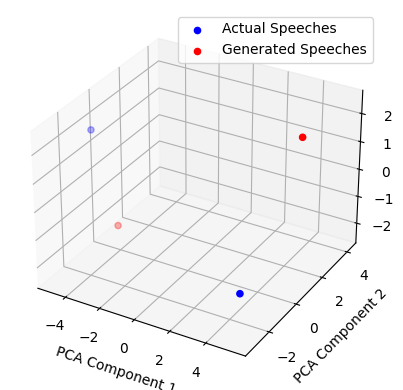

In [13]:
import nltk
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from transformers import BartTokenizer, BartModel
import torch

# Sample speeches (replace these with your actual speeches)
actual_speeches = [
    "I am honored to be here today. Our country faces many challenges, but together, we can overcome them.",
    "The future of our nation is bright, and I will work tirelessly to ensure a better tomorrow for all.",
]

generated_speeches = [
    "I am humbled to be present in this gathering. Our nation confronts numerous obstacles, but united, we shall prevail.",
    "The destiny of our land is promising, and I will tirelessly strive to guarantee a brighter future for everyone.",
]

# Preprocess the texts (optional but recommended)
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = " ".join(nltk.word_tokenize(text))  # Tokenize text into words
    return text

# Download 'punkt' tokenizer data (if not already downloaded)
nltk.download('punkt')

# Preprocess the actual and generated speeches
actual_speeches = [preprocess_text(text) for text in actual_speeches]
generated_speeches = [preprocess_text(text) for text in generated_speeches]

# Load BART tokenizer and model
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
model = BartModel.from_pretrained('facebook/bart-large')

# Function to create embeddings from text using BART
def create_bart_embeddings(text):
    input_ids = tokenizer.encode(text, return_tensors="pt", add_special_tokens=True)
    with torch.no_grad():
        output = model(input_ids)
    embeddings = output.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

# Create embeddings for actual speeches and generated speeches
actual_embeddings = [create_bart_embeddings(text) for text in actual_speeches]
generated_embeddings = [create_bart_embeddings(text) for text in generated_speeches]

# Remove None embeddings (if any)
actual_embeddings = [embed for embed in actual_embeddings if embed is not None]
generated_embeddings = [embed for embed in generated_embeddings if embed is not None]

# Calculate cosine similarity between embeddings
cosine_similarity = np.dot(actual_embeddings, np.array(generated_embeddings).T) / (
    np.linalg.norm(actual_embeddings, axis=1)[:, None] * np.linalg.norm(np.array(generated_embeddings), axis=1)
)

# Print cosine similarity for each speech pair
print("Cosine Similarity:")
for i in range(len(actual_speeches)):
    for j in range(len(generated_speeches)):
        print(f"Speech Pair ({i+1}, {j+1}): {cosine_similarity[i, j]}")

# Apply PCA to reduce dimensionality to 3D
pca = PCA(n_components=3)
pca_embeddings = pca.fit_transform(np.concatenate((actual_embeddings, generated_embeddings), axis=0))

# Separate the PCA embeddings back to actual and generated
actual_pca_embeddings = pca_embeddings[: len(actual_embeddings)]
generated_pca_embeddings = pca_embeddings[len(actual_embeddings) :]

# Visualize the embeddings in a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(actual_pca_embeddings[:, 0], actual_pca_embeddings[:, 1], actual_pca_embeddings[:, 2], c='blue', label='Actual Speeches')
ax.scatter(generated_pca_embeddings[:, 0], generated_pca_embeddings[:, 1], generated_pca_embeddings[:, 2], c='red', label='Generated Speeches')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend()
plt.show()
